In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
print(device)
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_summary())

cuda
NVIDIA GeForce RTX 4070 Laptop GPU
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool 

In [19]:
dataset = "data/filtered_0001.csv"
df = pd.read_csv(dataset)

In [20]:
X = df.drop(columns=["Genotype","Phenotype"])
y = df["Phenotype"]

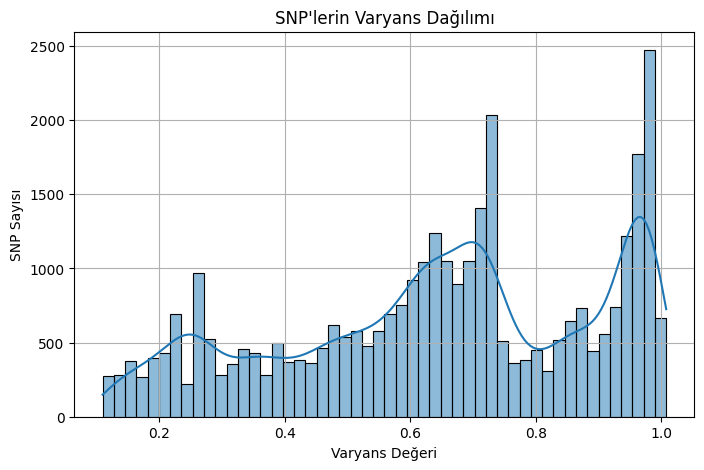

25. yüzdelik dilim (Q1): 0.47243107769423553
Medyan (Q2): 0.670995670995671
75. yüzdelik dilim (Q3): 0.866598313966735
Önerilen Threshold Değeri: 0.47243107769423553


In [21]:
import seaborn as sns
variances = X.var(axis=0)

plt.figure(figsize=(8, 5))
sns.histplot(variances, bins=50, kde=True)
plt.xlabel("Varyans Değeri")
plt.ylabel("SNP Sayısı")
plt.title("SNP'lerin Varyans Dağılımı")
plt.grid()
plt.show()


q25 = variances.quantile(0.25)  # 25. yüzdelik dilim
median = variances.median()      # Medyan (50. yüzdelik dilim)
q75 = variances.quantile(0.75)  # 75. yüzdelik dilim

print(f"25. yüzdelik dilim (Q1): {q25}")
print(f"Medyan (Q2): {median}")
print(f"75. yüzdelik dilim (Q3): {q75}")

optimal_threshold = q25
print(f"Önerilen Threshold Değeri: {optimal_threshold}")

In [22]:
var_thresh = VarianceThreshold(0.05)
X_var_filtered = pd.DataFrame(var_thresh.fit_transform(X), columns=X.columns[var_thresh.get_support()])
print(f"1. Varyans filtresinden sonra kalan SNP sayısı: {X_var_filtered.shape[1]}")

1. Varyans filtresinden sonra kalan SNP sayısı: 33971


In [23]:
X_var_filtered = np.array(X_var_filtered)
y = np.array(y)

In [24]:
# Train-Test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_var_filtered, y, test_size=0.2)

# Further split train into train/val (80/20 split of the train set)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2)

In [25]:
class SNPPhenotypeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float().unsqueeze(1)
        self.y = torch.from_numpy(y).float().unsqueeze(-1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SNPPhenotypeDataset(X_train, y_train)
val_dataset   = SNPPhenotypeDataset(X_val, y_val)
test_dataset  = SNPPhenotypeDataset(X_test, y_test)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
class CNNRegressor(nn.Module):
    def __init__(self, input_length):
        super(CNNRegressor, self).__init__()
        self.conv_net = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.MaxPool1d(kernel_size=2),
            nn.Tanh(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.MaxPool1d(kernel_size=2),
            nn.Tanh()
        )

        # Dense part
        self.fc1 = nn.Linear(32 * (input_length // 4), 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv_net(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate model
input_length = X_train.shape[1]  # D, number of features after feature selection
model = CNNRegressor(input_length)

In [27]:
model.to(device)

criterion = nn.MSELoss()  # We'll measure MSE for training
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Early stopping parameters
patience = 10
best_val_loss = float("inf")
epochs_no_improve = 0
max_epochs = 200

In [12]:
train_losses = []
val_losses   = []

for epoch in range(max_epochs):
    model.train()
    running_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * batch_X.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_val_loss += loss.item() * batch_X.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{max_epochs}] | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}")

    # Early Stopping Check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/200] | Train Loss: 178.6369 | Val Loss: 2.4037
Epoch [2/200] | Train Loss: 8.1252 | Val Loss: 2.0765
Epoch [3/200] | Train Loss: 4.2543 | Val Loss: 1.7202
Epoch [4/200] | Train Loss: 1.6271 | Val Loss: 1.2479
Epoch [5/200] | Train Loss: 0.6278 | Val Loss: 1.0543
Epoch [6/200] | Train Loss: 0.3936 | Val Loss: 1.5864
Epoch [7/200] | Train Loss: 0.2375 | Val Loss: 1.3412
Epoch [8/200] | Train Loss: 0.4208 | Val Loss: 1.3039
Epoch [9/200] | Train Loss: 0.6278 | Val Loss: 1.9868
Epoch [10/200] | Train Loss: 0.3480 | Val Loss: 1.2608
Epoch [11/200] | Train Loss: 0.2602 | Val Loss: 1.1446
Epoch [12/200] | Train Loss: 0.0863 | Val Loss: 1.1909
Epoch [13/200] | Train Loss: 0.1147 | Val Loss: 1.5042
Epoch [14/200] | Train Loss: 0.1403 | Val Loss: 1.1123
Epoch [15/200] | Train Loss: 0.1236 | Val Loss: 1.3439
Early stopping triggered!


In [13]:
model.load_state_dict(best_model_state)

model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(batch_y.numpy())

y_pred = np.concatenate(all_preds).reshape(-1)
y_true = np.concatenate(all_targets).reshape(-1)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

print("\n=== Final Evaluation on Test Set ===")
print(f"MSE:  {mse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R^2:  {r2:.4f}")


=== Final Evaluation on Test Set ===
MSE:  1.3971
MAE:  0.9956
R^2:  -0.0246


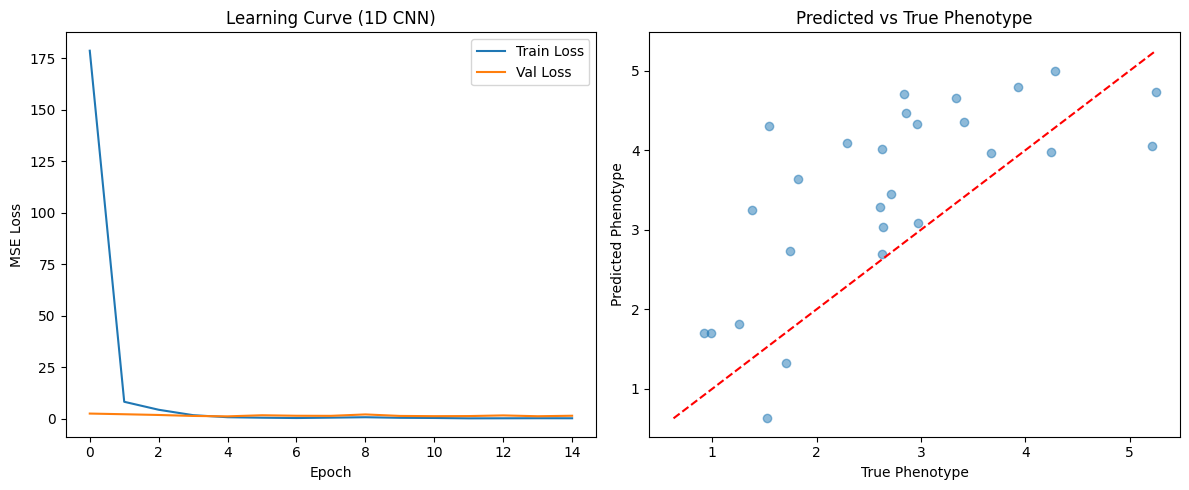

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Learning Curve (1D CNN)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

# 8.2 Predicted vs. True
plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.5)
min_val = min(min(y_true), min(y_pred))
max_val = max(max(y_true), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title("Predicted vs True Phenotype")
plt.xlabel("True Phenotype")
plt.ylabel("Predicted Phenotype")

plt.tight_layout()
plt.show()

In [28]:
PATH = "CNN_models/best_1DCNN_v1.pth"
torch.save(model.state_dict(), PATH)

In [29]:
new_model = CNNRegressor(X_train.shape[1])
new_model.load_state_dict(torch.load(PATH, map_location=device))  
new_model = new_model.to(device) 
new_model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = new_model(batch_X)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(batch_y.numpy())

y_pred = np.concatenate(all_preds).reshape(-1)
y_true = np.concatenate(all_targets).reshape(-1)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

print("\n=== Final Evaluation on Test Set ===")
print(f"MSE:  {mse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R^2:  {r2:.4f}")

C:\Users\LEGION\AppData\Local\Temp\ipykernel_11148\327352143.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load(PATH, map_location=devi


=== Final Evaluation on Test Set ===
MSE:  10.2231
MAE:  2.7681
R^2:  -3.0099


In [ ]:
import glob
import os
import pandas as pd 

folder_path = "raw"  
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

df_list = []
for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv("combined_output.csv", index=False)


dataset_name = dataset.split("/")[-1:][0]
variance_threshold = optimal_threshold

model_stats = {
    "dataset": [dataset_name],
    "dataset size" : df.shape[1],
    "variance_threshold": [variance_threshold],
    "dataset size after vt" : X_var_filtered.shape[1],
    "MSE": [round(mse,3)],
    "MAE": [round(mae,3)],
    "R2": [round(r2,3)]
}

model_stats_df = pd.DataFrame(model_stats)
model_stats_df.to_csv(f"raw/{dataset_name}_stats_05_005.csv", index=False)

In [ ]:
df = pd.v("combined_output.csv")

,dataset,dataset size,variance_threshold,dataset size after vt,MSE,MAE,R2
0,filtered_00001.csv,20696,0.576441,20694,0.899,0.736,0.554
1,filtered_00001.csv,20696,0.576441,20694,0.660,0.634,0.674
2,filtered_00001.csv,20696,0.576441,20694,0.712,0.638,0.537
3,filtered_00001.csv,20696,0.576441,20694,0.719,0.690,0.553
4,filtered_00001.csv,20696,0.576441,20694,0.858,0.705,0.553
5,filtered_0001.csv,33973,0.472431,33971,0.815,0.754,0.536
6,filtered_0001.csv,33973,0.472431,33971,0.813,0.704,0.533
7,filtered_0001.csv,33973,0.472431,33971,0.778,0.731,0.659
8,filtered_0001.csv,33973,0.472431,33971,0.924,0.779,0.538
9,filtered_0001.csv,33973,0.472431,33971,0.514,0.614,0.734


In [ ]:
PATH = "CNN_models/best_1DCNN_v2.pth"
new_model = CNNRegressor(X_train.shape[1])
new_model.load_state_dict(torch.load(PATH, map_location=device))  
new_model = new_model.to(device) 
new_model.eval()

C:\Users\LEGION\AppData\Local\Temp\ipykernel_11148\3427000238.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load(PATH, map_location=dev

CNNRegressor(
  (conv_net): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Tanh()
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Tanh()
  )
  (fc1): Linear(in_features=271744, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)